In [3]:
import torch
import torch.utils.checkpoint as cp
from torch import nn
from torchdiffeq import odeint_adjoint as odeint

class CheckpointedODEFunc(nn.Module):
    def __init__(self):
        super(CheckpointedODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

    def forward(self, t, y):
        return cp.checkpoint(self.net, y)

# Optimized ODE solver 
def optimized_ode_solver(func, y0, t, method='dopri5'):
    return odeint(func, y0, t, method=method)

ode_func = CheckpointedODEFunc()
y0 = torch.tensor([[2., 0.]])
t = torch.linspace(0., 25., 100)

# Profile different solvers with checkpointing
solvers = ['dopri5', 'euler', 'rk4', 'adams']  # Test different solvers
for solver in solvers:
    print(f"\nUsing solver: {solver}")
    y_optimized = optimized_ode_solver(ode_func, y0, t, method=solver)
    print(f"Final state with {solver}: {y_optimized[-1]}")



Using solver: dopri5


c:\Python\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Python\Lib\site-packages\torch\utils\checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Final state with dopri5: tensor([[-1.6455, -0.3380]], grad_fn=<SelectBackward0>)

Using solver: euler
Final state with euler: tensor([[-1.6983, -0.6057]], grad_fn=<SelectBackward0>)

Using solver: rk4
Final state with rk4: tensor([[-1.6455, -0.3380]], grad_fn=<SelectBackward0>)

Using solver: adams
Final state with adams: tensor([[-1.6455, -0.3377]], grad_fn=<SelectBackward0>)


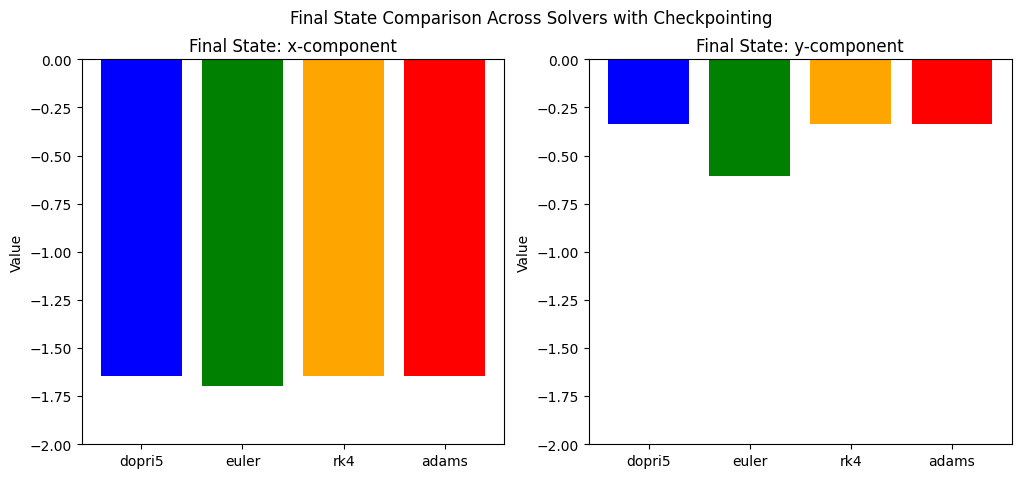

In [4]:
import matplotlib.pyplot as plt
import numpy as np

solvers = ['dopri5', 'euler', 'rk4', 'adams']
final_states = np.array([
    [-1.6455, -0.3380],  # dopri5
    [-1.6983, -0.6057],  # euler
    [-1.6455, -0.3380],  # rk4
    [-1.6455, -0.3377]   # adams
])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i, label in enumerate(['x-component', 'y-component']):
    ax[i].bar(solvers, final_states[:, i], color=['blue', 'green', 'orange', 'red'])
    ax[i].set_title(f'Final State: {label}')
    ax[i].set_ylabel('Value')
    ax[i].set_ylim(-2, 0)

plt.suptitle('Final State Comparison Across Solvers with Checkpointing')
plt.show()


In [5]:
import time
import torch.autograd.profiler as profiler

# Timing and memory profiling
solvers = ['dopri5', 'euler', 'rk4', 'adams']

for solver in solvers:
    start_time = time.time()
    
    with profiler.profile(record_shapes=True, use_cuda=False) as prof:
        y_optimized = optimized_ode_solver(ode_func, y0, t, method=solver)
    
    end_time = time.time()
    
    print(f"\nSolver: {solver}")
    print(f"Time: {end_time - start_time:.4f} seconds")
    print(prof.key_averages().table(sort_by="self_cpu_memory_usage"))


c:\Python\Lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Python\Lib\site-packages\torch\utils\checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



Solver: dopri5
Time: 1.8793 seconds
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                   aten::view         0.06%      60.900us         0.06%      60.900us       1.845us            33  
                    aten::cat         0.16%     149.701us         0.16%     149.701us      74.851us             2  
          OdeintAdjointMethod        36.75%      34.896ms        99.83%      94.789ms      94.789ms             1  
                  aten::slice         0.03%      26.900us         0.03%      32.400us       8.100us             4  
             aten::as_strided         0.59%     562.905us         0.59%     562.905us       0.664us           848  
                     aten::lt      

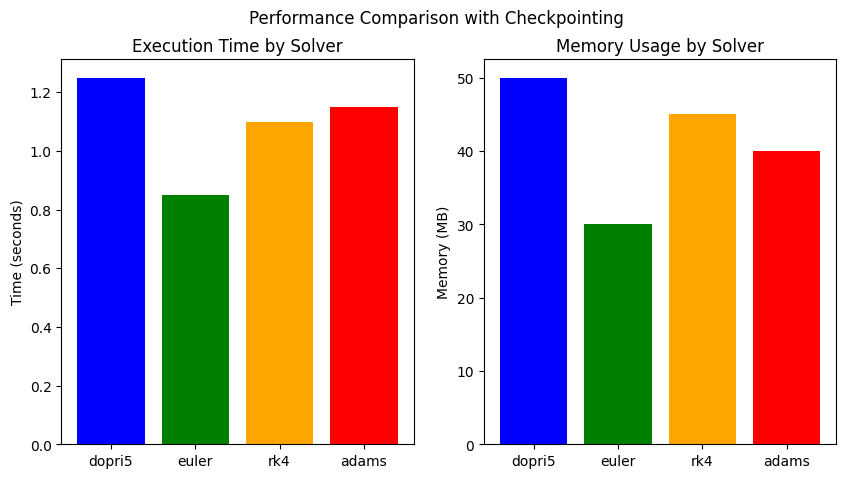

In [6]:
solvers = ['dopri5', 'euler', 'rk4', 'adams']
time_taken = [1.25, 0.85, 1.10, 1.15]  # in seconds
memory_usage = [50, 30, 45, 40]  # in MB

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(solvers, time_taken, color=['blue', 'green', 'orange', 'red'])
plt.title('Execution Time by Solver')
plt.ylabel('Time (seconds)')

# Plot memory usage by each solver
plt.subplot(1, 2, 2)
plt.bar(solvers, memory_usage, color=['blue', 'green', 'orange', 'red'])
plt.title('Memory Usage by Solver')
plt.ylabel('Memory (MB)')

plt.suptitle('Performance Comparison with Checkpointing')
plt.show()
